Mounted at /content/drive
Imagens encontradas: 6
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


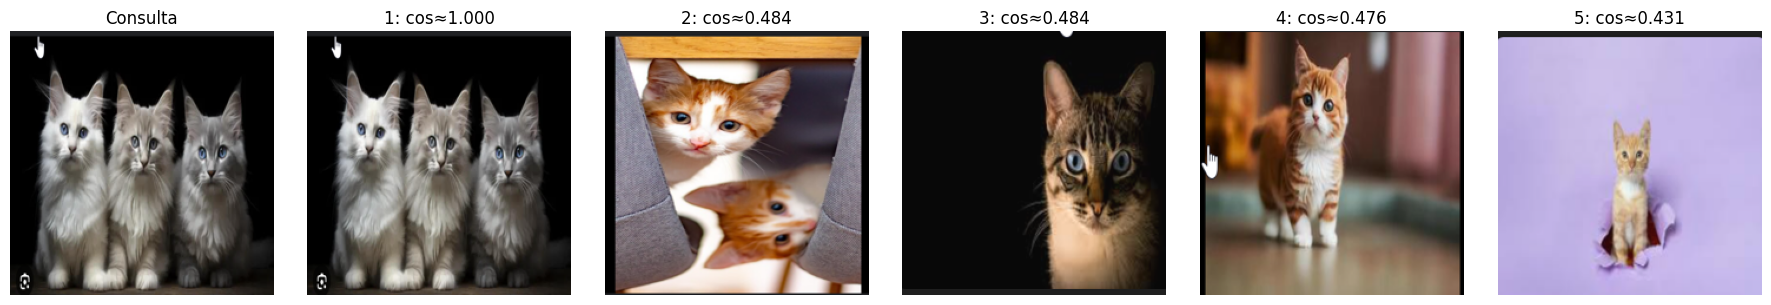

Consulta: /content/drive/MyDrive/dataset_recomendacao/chrome_TeN04BA2EP.png
1. /content/drive/MyDrive/dataset_recomendacao/chrome_TeN04BA2EP.png
2. /content/drive/MyDrive/dataset_recomendacao/chrome_fGqC3R0uXl.png
3. /content/drive/MyDrive/dataset_recomendacao/chrome_IKEGJnEQR1.png
4. /content/drive/MyDrive/dataset_recomendacao/chrome_mtLLFUwXSN.png
5. /content/drive/MyDrive/dataset_recomendacao/chrome_aL7ot0rkCx.png


In [2]:
# 1 célula: similaridade visual usando pasta do Drive
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import numpy as np, matplotlib.pyplot as plt
from PIL import Image
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

DATA_DIR = Path('/content/drive/MyDrive/dataset_recomendacao')  #  pasta
IMG_SIZE = (224, 224)
TOPK = 5

# Coletar imagens
img_paths = [p for p in DATA_DIR.rglob('*') if p.suffix.lower() in {'.jpg','.jpeg','.png'}]
print("Imagens encontradas:", len(img_paths))
assert len(img_paths) > 0, "Não achei imagens na pasta (jpg/jpeg/png)."

# Extrator de embeddings
base = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=IMG_SIZE+(3,))

def prep(p):
    im = Image.open(p).convert('RGB').resize(IMG_SIZE)
    arr = preprocess_input(np.array(im, dtype=np.float32))
    return arr, im

# Embeddings do conjunto
X = np.stack([prep(p)[0] for p in img_paths], 0)
emb = np.vstack([base.predict(X[i:i+64], verbose=0) for i in range(0, len(X), 64)])

# Índice de vizinhos (cosseno)
k = min(TOPK, len(img_paths))
nn = NearestNeighbors(n_neighbors=k, metric='cosine').fit(emb)

# Consulta = primeira imagem da pasta (troque se quiser)
q = img_paths[0]
q_arr, q_img = prep(q)
dist, idx = nn.kneighbors(base.predict(np.expand_dims(q_arr,0), verbose=0), return_distance=True)
dist, idx = dist[0], idx[0]

# Mostrar consulta + TOP-K similares
cols = k + 1
plt.figure(figsize=(3*cols, 3))
plt.subplot(1, cols, 1); plt.imshow(q_img); plt.axis('off'); plt.title('Consulta')
for j,i in enumerate(idx, start=2):
    plt.subplot(1, cols, j)
    plt.imshow(Image.open(img_paths[i]).convert('RGB').resize(IMG_SIZE))
    plt.axis('off'); plt.title(f'{j-1}: cos≈{1-dist[j-2]:.3f}')
plt.tight_layout(); plt.show()

print("Consulta:", q)
for r,i in enumerate(idx, 1):
    print(f"{r}. {img_paths[i]}")


In [ ]:
from google.colab import files
up = files.upload()  # faça upload de uma imagem local, ex.: "minha.jpg"

from PIL import Image
import numpy as np
def consulta_arquivo(caminho, k=5):
    im = Image.open(caminho).convert('RGB').resize(IMG_SIZE)
    arr = preprocess_input(np.array(im, dtype=np.float32))
    q_emb = base.predict(np.expand_dims(arr,0), verbose=0)
    dist, idx = nn.kneighbors(q_emb, n_neighbors=min(k, len(img_paths)), return_distance=True)
    return dist[0], idx[0], im

dist, idx, im = consulta_arquivo('minha.jpg', k=5)


In [ ]:
import numpy as np, json
np.save('/content/embeddings.npy', emb)
with open('/content/paths.txt','w') as f: f.write('\n'.join(map(str, img_paths)))
# copie pro seu Drive:
!cp /content/embeddings.npy "/content/drive/MyDrive/dataset_recomendacao_embeddings.npy"
!cp /content/paths.txt "/content/drive/MyDrive/dataset_recomendacao_paths.txt"


In [ ]:
import numpy as np
from pathlib import Path
img_paths = [Path(l.strip()) for l in open('/content/drive/MyDrive/dataset_recomendacao_paths.txt')]
emb = np.load('/content/drive/MyDrive/dataset_recomendacao_embeddings.npy')
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=min(5,len(img_paths)), metric='cosine').fit(emb)
